In [1]:
import argparse
import sys
from pathlib import Path

import cv2

# import nrrd
import gc

import numpy as np

import os
import SimpleITK as sitk
from scipy.interpolate import RegularGridInterpolator

import pydicom as dicom

import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy import ndimage

import glob

# !pip install nibabel
import nibabel as nib


In [2]:

def interp3(x,y,z,img_org, xr,yr,zr):
    """resampling"""
    
    xi,yi,zi = np.meshgrid(xr, yr, zr, indexing='ij')
    min_val = np.min(img_org)

    interp = RegularGridInterpolator((x,y,z),img_org,bounds_error=False,fill_value=min_val)
    img = interp( (xi,yi,zi)).astype(np.float32)
    
    return img


def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz
   

In [3]:
def plot_slice(ploting_ax, img,slice,axis):
    '''
        Plot img along a specific axis.
    '''

    if axis==0:
        ploting_ax.imshow(img[slice])
    elif axis==1:
        ploting_ax.imshow(img[:,slice,:])
    elif axis==2:
        ploting_ax.imshow(img[:,:,slice])
    return ploting_ax

def plot_img_at(img, coord):
    '''
        Plot the 3D slicing view of img at coord.
    '''

    l,p,s = coord
    
    axis_label ={"L":"L: right to left",
                 "P":"P: front to back",
                 "S":"S: feet to head"}

    ax = plt.subplot(1, 3, 1)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(axis_label["P"])
    ax.set_xlabel(axis_label["S"])
    ax.invert_yaxis()

    ax.imshow(np.squeeze(img[l,:,:]))
    

    ax = plt.subplot(1, 3, 2)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(axis_label["L"])
    ax.set_xlabel(axis_label["S"])
    ax.invert_yaxis()

    
    ax.imshow(np.squeeze(img[:,p,:]))
    

    ax = plt.subplot(1, 3, 3)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(axis_label["L"])
    ax.set_xlabel(axis_label["P"])
    ax.invert_yaxis()


    ax.imshow(np.squeeze(img[:,:,s]))
    
    return ax
def sitk2numpy(sitk_img):
    '''
        Return a numpy array that has the same shape as the sitk image.
    '''
    out = (sitk.GetArrayFromImage(sitk_img)).astype(np.float32)
    return out


# Coordinate system definition: LPS format

Reference: https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DICOMOrientImageFilter.html

Directions are labeled in terms of following pairs:

- Left and Right (Subject's left and right)
- Anterior and Posterior (Subject's front and back)
- Inferior and Superior (Subject's bottom and top, i.e. feet and head)

An ITK image with an identity direction cosine matrix is in LPS (Left, Posterior, Superior) orientation as defined by the DICOM standard.

$$ 𝐿𝑃𝑆= \begin{bmatrix}
        \text{𝑓𝑟𝑜𝑚 𝑟𝑖𝑔ℎ𝑡 𝑡𝑜 𝐋𝑒𝑓𝑡}\\
        \text{𝑓𝑟𝑜𝑚 anterior(front) 𝑡𝑜𝑤𝑎𝑟𝑑𝑠 𝐏𝑜𝑠𝑡𝑒𝑟𝑖𝑜𝑟(back)}\\
        \text{𝑓𝑟𝑜𝑚 𝑖𝑛𝑓𝑒𝑟𝑖𝑜𝑟(feet) 𝑡𝑜𝑤𝑎𝑟𝑑𝑠 𝐒𝑢𝑝𝑒𝑟𝑖𝑜𝑟(head)}
        \end{bmatrix} $$



In [4]:
vessel_ct = sitk.ReadImage('vessel_ct.nii.gz')


In [5]:
print(vessel_ct.GetOrigin())

(0.0, 0.0, 0.0)


In [6]:
## resampling reference size and resolution

ref_dx, ref_dy, ref_dz = 1.0, 1.0, 1.0
ref_nx, ref_ny, ref_nz = 384, 384, 384

xr = (np.linspace(0, ref_nx-1, ref_nx) - (ref_nx-1)/2.0)*ref_dx
yr = (np.linspace(0, ref_ny-1, ref_ny) - (ref_ny-1)/2.0)*ref_dy
zr = (np.linspace(0, ref_nz-1, ref_nz) - (ref_nz-1)/2.0)*ref_dz

In [7]:
ct_shape = vessel_ct.GetSize()
ct_res = vessel_ct.GetSpacing()

In [8]:
print(ct_shape)
print(ct_res)

(512, 512, 256)
(0.699999988079071, 0.699999988079071, 0.699999988079071)


# The CT image has already satisfied the LPS format. We conform the US image to satisfy LPS format next

(0.0, 0.0, 0.0)
(500, 1080, 50) (0.1875, 0.1875, 0.8059622049331665)


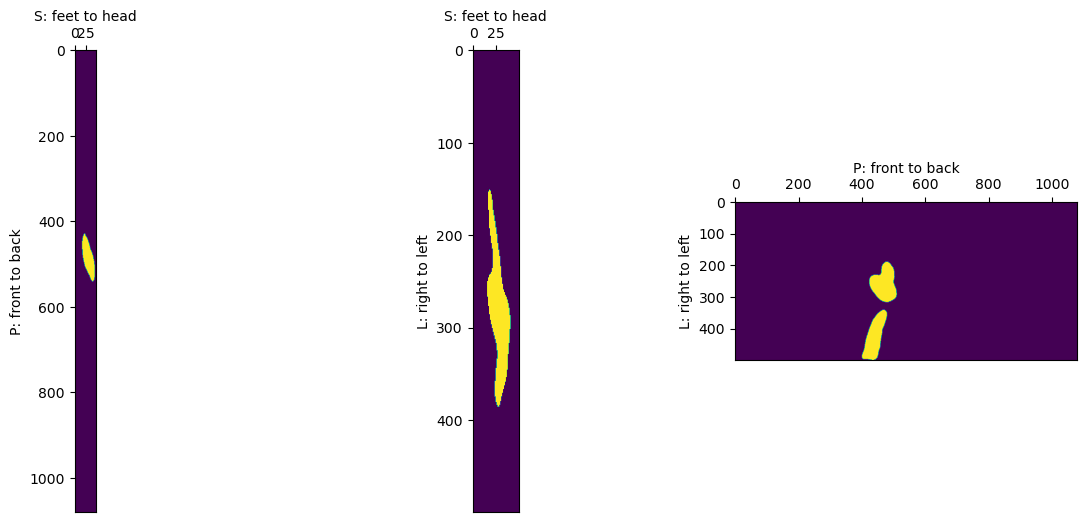

In [9]:
o = [True,False,True]
vessel_us = sitk.ReadImage('vessel_linear_scan_dense_25_us.nii')
print(vessel_us.GetOrigin())


vessel_us = sitk.PermuteAxes(vessel_us,[2,1,0])

vessel_us = sitk.Flip(vessel_us,o)

# vessel_us=us_preproc.Execute(vessel_us)

us_shape = vessel_us.GetSize()
us_res = vessel_us.GetSpacing()
print(us_shape,us_res)

us_img_0 = (sitk.GetArrayFromImage(vessel_us)).astype(np.float32)
# z,y,x->x,y,z
us_img_0 = np.swapaxes(us_img_0,0,2)

plt.figure(figsize=(15,6))

plot_img_at(us_img_0,np.array(centroid3(us_img_0)).astype(int))
plt.show()

In [10]:
tmp_ct_img = (sitk.GetArrayFromImage(vessel_ct)).astype(np.float32)
# z,y,x->x,y,z
tmp_ct_img = np.swapaxes(tmp_ct_img,0,2)

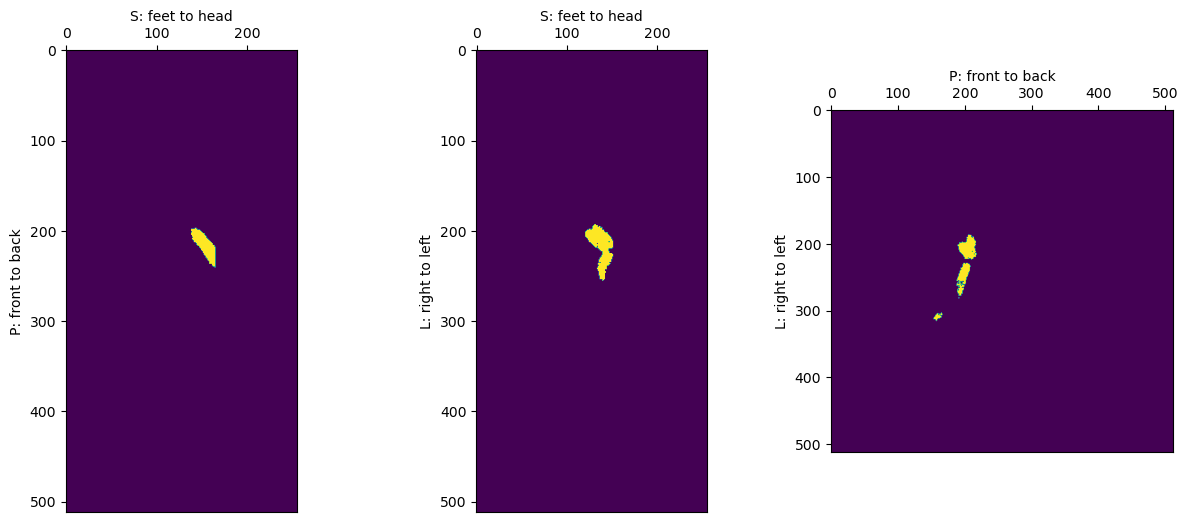

In [11]:
plt.figure(figsize=(15,6))


plot_img_at(tmp_ct_img,np.array(centroid3(tmp_ct_img)).astype(int))
plt.show()

In [12]:
## resampling ct and ultrasound images
x = (np.linspace(0, ct_shape[0]-1, ct_shape[0]) - (ct_shape[0]-1)/2.0)*ct_res[0]
y = (np.linspace(0, ct_shape[1]-1, ct_shape[1]) - (ct_shape[1]-1)/2.0)*ct_res[1]
z = (np.linspace(0, ct_shape[2]-1, ct_shape[2]) - (ct_shape[2]-1)/2.0)*ct_res[2]
img_ct = interp3(x, y, z, tmp_ct_img, xr, yr, zr)

###### The center pixel of us_img_0 is defined as the origin of the cartesian continuous coordinate frame ######
x = (np.linspace(0, us_shape[0]-1, us_shape[0]) - (us_shape[0]-1)/2.0)*us_res[0] 
y = (np.linspace(0, us_shape[1]-1, us_shape[1]) - (us_shape[1]-1)/2.0)*us_res[1]
z = (np.linspace(0, us_shape[2]-1, us_shape[2]) - (us_shape[2]-1)/2.0)*us_res[2]
us_img_1 = interp3(x, y, z, us_img_0, xr, yr, zr)
###### The center pixel of us_img_1 and has the same continuous coordinate as the center pixel of us_img_0. ######

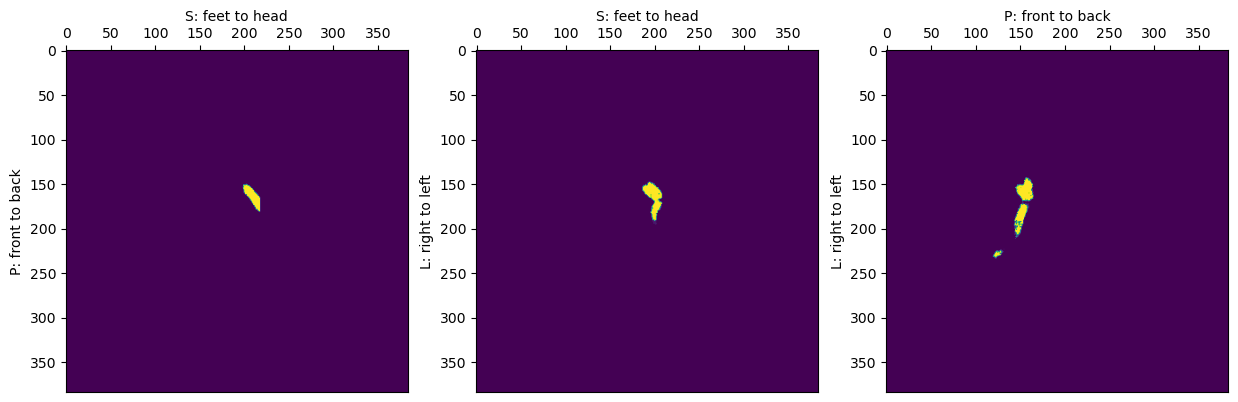

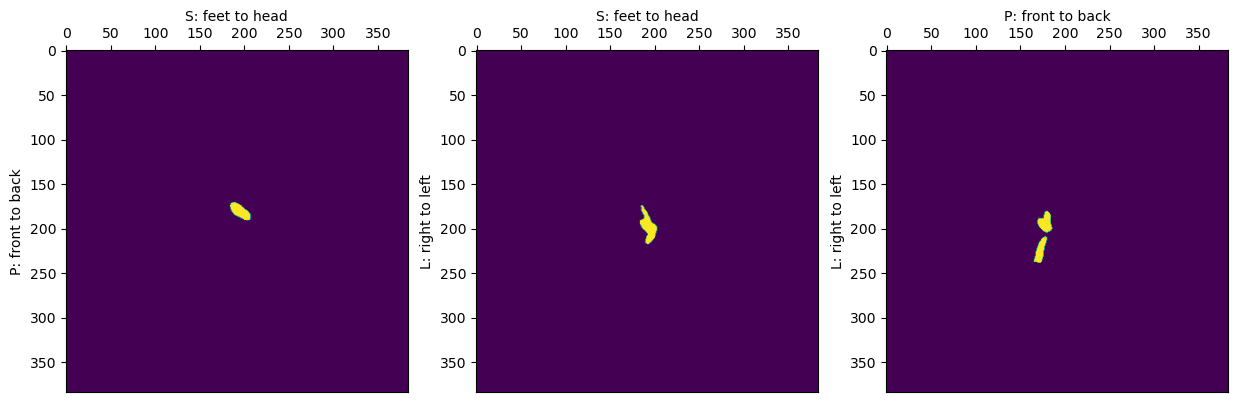

In [13]:
plt.figure(figsize=(15,6))
tmp = img_ct
plot_img_at(tmp,np.array(centroid3(tmp)).astype(int))
plt.show()

# adjust to the same image shape and direction >> depending on the probe position: need to be fixed.
plt.figure(figsize=(15,6))
tmp = us_img_1
plot_img_at(tmp,np.array(centroid3(tmp)).astype(int))
plt.show()

In [14]:
# set the fixed image: CT
fixed_image = sitk.GetImageFromArray(img_ct.astype(np.float32)) 
fixed_image.SetSpacing((ref_dx,ref_dy,ref_dz))
sitk.WriteImage(fixed_image,'vessel_ct_resample.nii.gz')

In [15]:
# First, we calculate the centroid and move (=attach) ultrasound image to ct image

cx_us, cy_us, cz_us = np.round(centroid3(np.squeeze(us_img_1))).astype(np.int32)
cx_ct, cy_ct, cz_ct = np.round(centroid3(np.squeeze(img_ct))).astype(np.int32)
diff_x = cx_us-cx_ct
diff_y = cy_us-cy_ct
diff_z = cz_us-cz_ct
print("Coordinate difference:\t (diff_x, diff_y, diff_z) = (%d, %d, %d)"%(diff_x, diff_y, diff_z))
print("Resolution: \t\t (res_x, res_y, res_z) = (%.2f, %.2f, %.2f)"%(ref_dx,ref_dy,ref_dz))

Coordinate difference:	 (diff_x, diff_y, diff_z) = (25, 24, -8)
Resolution: 		 (res_x, res_y, res_z) = (1.00, 1.00, 1.00)


In [1]:
# Usually vessel images are apart from each other. 
# Move the ultrasound image using centroid: now ultrasound and ct vessels are close, which is good for the rigid registration. 

img_us_move_centroid = interp3((xr-diff_x), (yr-diff_y), (zr-diff_z), us_img_1, xr, yr, zr)
moving_image = sitk.GetImageFromArray(img_us_move_centroid)
moving_image.SetSpacing((ref_dx,ref_dy,ref_dz))
sitk.WriteImage(moving_image,'vessel_us_resample.nii.gz')

NameError: name 'interp3' is not defined

In [17]:
## https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [18]:
num_iter = 2
for ii in range(num_iter):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=20)
    registration_method.SetMetricSamplingStrategy(registration_method.REGULAR )
    registration_method.SetMetricSamplingPercentage(0.2)    
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=30, convergenceMinimumValue=1e-7, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Setup for the multi-resolution framework.            
    # registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    # registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    # registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # Don't optimize in-place. We want to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    rigid_transform = registration_method.Execute(fixed_image, moving_image)

In [19]:
print(rigid_transform)

itk::simple::CompositeTransform
 CompositeTransform (0x1579af270)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 45306531
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x151ce2c80)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 45306377
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999998 0.00202766 0.00071193 
       -0.00203253 0.999974 0.00690981 
       -0.000697901 -0.00691124 0.999976 
     Offset: [-1.61569, -2.43673, 12.2637]
     Center: [191.5, 191.5, 191.5]
     Translation: [-1.0915, -1.5077, 10.8019]
     Inverse: 
       0.999998 -0.00203253 -0.000697901 
       0.00202766 0.999974 -0.00691124 
       0.00071193 0.00690981 0.999976 
     Singular: 0
     Euler's angles: AngleX=-0.00691129 AngleY=0.000697918 AngleZ=-0.00202771
     m_ComputeZYX = 0
  

In [20]:
moving_reg = sitk.Resample(moving_image, fixed_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_reg,'vessel_reg.nii.gz')

In [21]:
def loc2pixel(loc,spacing):
    spacing = np.array(spacing)
    return np.array(loc/spacing).astype(int)
def pixel2loc(pixel,spacing):
    spacing = np.array(spacing)
    return pixel * spacing

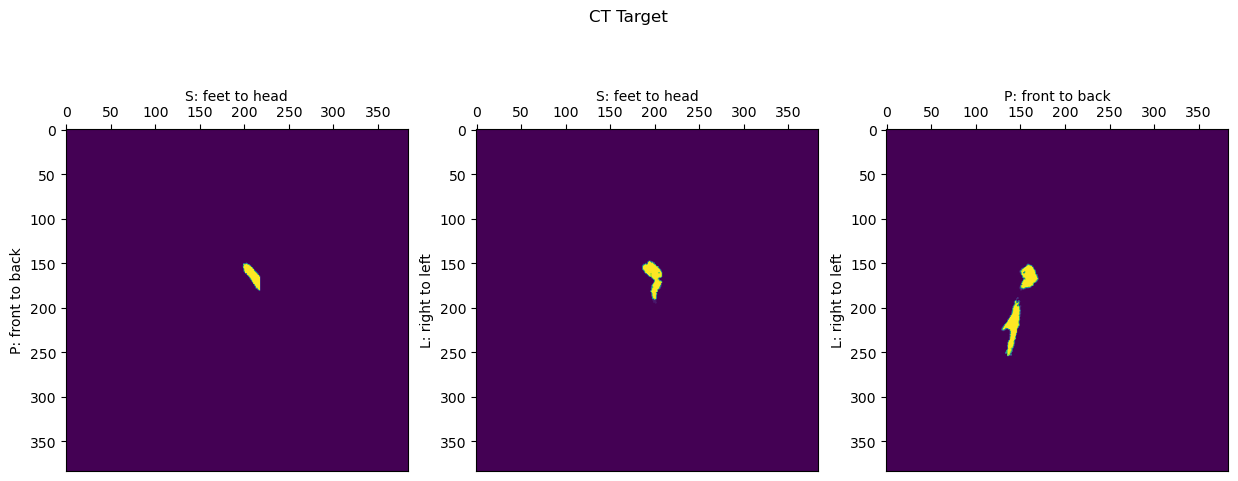

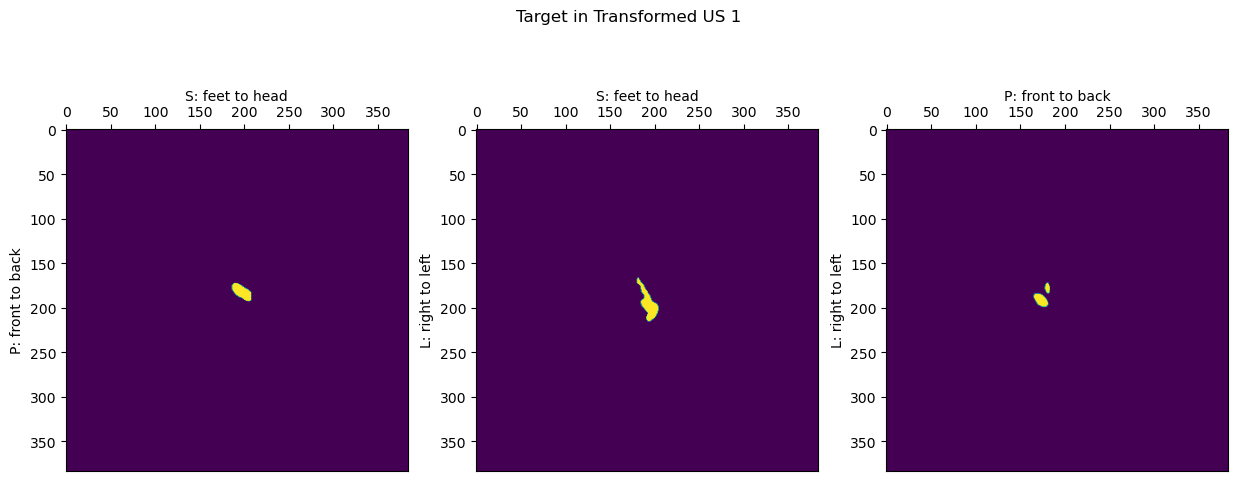

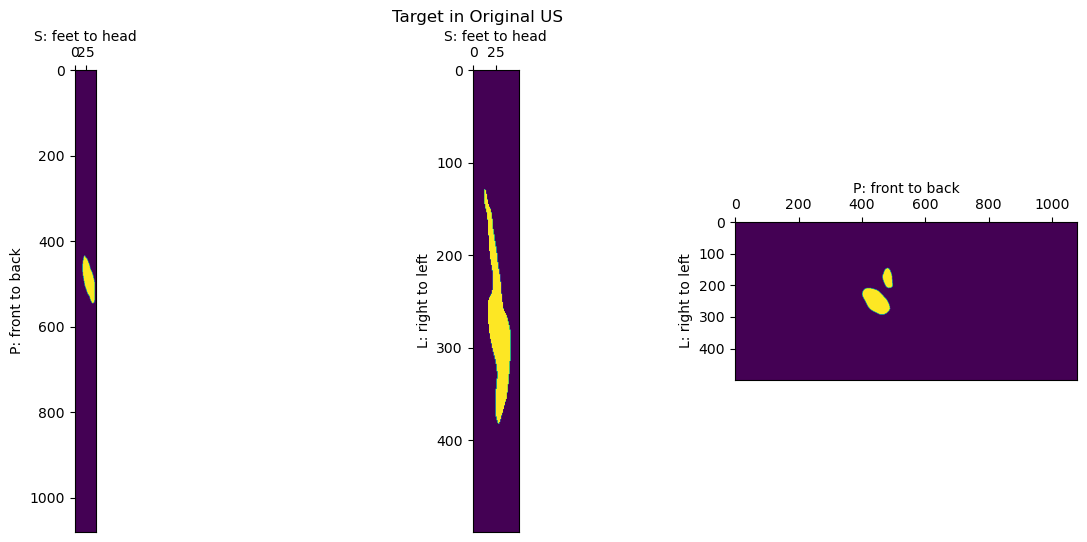

In [22]:
img_ct_final = (sitk.GetArrayFromImage(fixed_image)).astype(np.float32)
img_us_final = (sitk.GetArrayFromImage(moving_reg)).astype(np.float32)


target_loc = centroid3(img_ct_final)+ np.array([0,0,6])
# target_loc = np.array(centroid3(img_ct_final))
target_pixel = loc2pixel(target_loc,fixed_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(img_ct_final,target_pixel)
plt.suptitle("CT Target")
plt.show()

inv = rigid_transform.GetInverse()
us_loc_1 = inv.TransformPoint(target_loc.astype(float))
us_loc_1 += np.array([diff_x,diff_y,diff_z])
us_pixel_1 = loc2pixel(us_loc_1,moving_image.GetSpacing())

plt.figure(figsize=(15,6))
plot_img_at(us_img_1,us_pixel_1)
plt.suptitle("Target in Transformed US 1")
plt.show()


us_loc_0 = pixel2loc(us_pixel_1 - np.array(us_img_1.shape)/2,moving_image.GetSpacing())
us_pixel_0 = loc2pixel(us_loc_0,us_res)+np.array(us_img_0.shape)//2
plt.figure(figsize=(15,6))
plot_img_at(us_img_0,us_pixel_0)
plt.suptitle("Target in Original US")
plt.show()